# Sergey Sonkin Final Project

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import keras
from keras.models import Sequential 
from keras.layers import Dense, Dropout, Flatten 
from keras.layers import Conv2D, MaxPooling2D 
from keras.layers import Input
from keras.models import Model
from keras import backend as K 
import numpy as np
datadir= r"./drive/MyDrive/16th Grade/Final/"

# Part 1
## a) Importing data, showing histograms

### Importing data

In [ ]:
def get_fivedigit_data(shuffle=False):
    ## Getting data out of the directory
    data = np.float64(np.load(datadir+'data/gas_data.npy'))/255.
    labels = np.float32(np.load(datadir+'data/gas_labels.npy'))
    n = data.shape[0]
    ## Shuffling data
    if shuffle:
        order = np.random.permutation(n)
        data = data[order]
        labels = labels[order]
    ## Splitting data
    train_data = data[0:n//2].reshape((-1,85,195))
    train_labels = np.int32(labels[0:n//2])
    val_data = data[n//2:n*3//5].reshape((-1,85,195))
    val_labels = np.int32(labels[n//2:n*3//5])
    test_data = data[n*3//5:n].reshape((-1,85,195)) 
    test_labels = np.int32(labels[n*3//5:n])
    ## Formatting data for keras
    img_rows, img_cols = 85,195
    if K.image_data_format() == 'channels_first': 
        x_train = train_data.reshape(train_data.shape[0], 1, img_rows, img_cols) 
        x_val = val_data.reshape(val_data.shape[0], 1, img_rows, img_cols) 
        x_test = test_data.reshape(test_data.shape[0], 1, img_rows, img_cols) 
        input_shape = (1, img_rows, img_cols) 
    else: 
        x_train = train_data.reshape(train_data.shape[0], img_rows, img_cols, 1) 
        x_val = val_data.reshape(val_data.shape[0], img_rows, img_cols, 1) 
        x_test = test_data.reshape(test_data.shape[0], img_rows, img_cols, 1) 
        input_shape = (img_rows, img_cols, 1) 

    x_train = x_train.astype('float32') 
    x_val = x_val.astype('float32') 
    x_test = x_test.astype('float32') 

    y_train = keras.utils.to_categorical(train_labels, 10) 
    y_val = keras.utils.to_categorical(val_labels, 10) 
    y_test = keras.utils.to_categorical(test_labels, 10)
    
    return (x_train,y_train),(x_val,y_val),(x_test,y_test),input_shape

### Examining histograms

The results are below. 

What we observe is

1. The first digit is always 6 and it's not worth trying to predict it with our model. We can just treat it as predicting 6 every time which will have 100% accuracy.
2. The second digit is just a binary classification between 1 and 2. If we wanted to be super efficient about our model we could have our model for that digit just be a binary classification model instead of a prediction on 10 numbers
3. Digits 3 through 5 seem to be more uniform in nature, with the uniformity obviously increasing as we go towards the last digits because they change the most often.

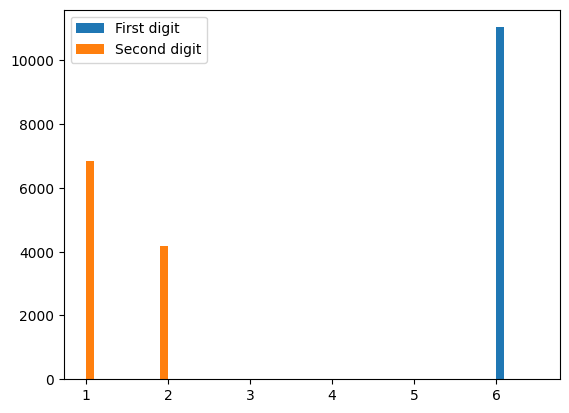

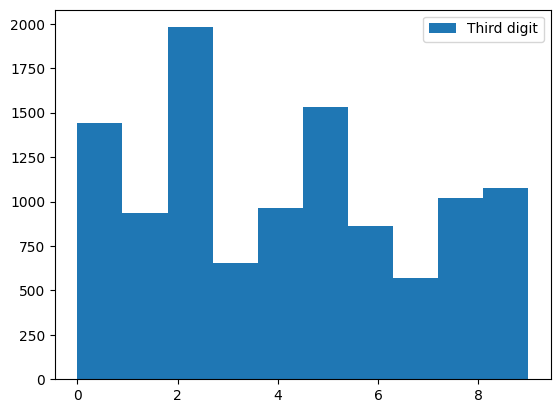

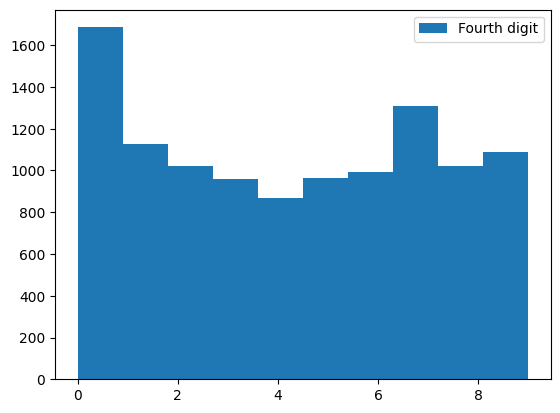

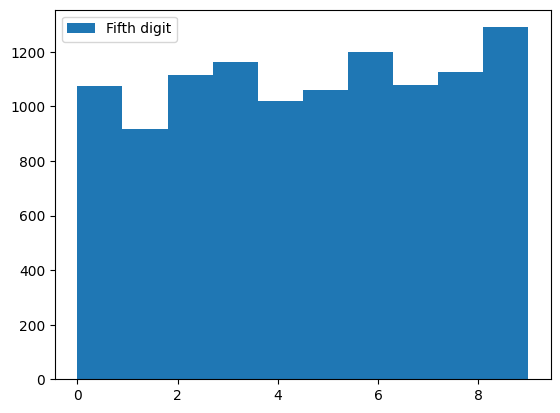

In [ ]:
import matplotlib.pyplot as plt
def examine_labels():
    labels = np.int32(np.load(datadir+'data/gas_labels.npy'))
    plt.hist(labels[:,0],bins=10,label="First digit")
    plt.hist(labels[:,1],bins=10,label="Second digit")
    plt.legend()
    plt.show()
    plt.hist(labels[:,2],bins=10,label="Third digit")
    plt.legend()
    plt.show()
    plt.hist(labels[:,3],bins=10,label="Fourth digit")
    plt.legend()
    plt.show()
    plt.hist(labels[:,4],bins=10,label="Fifth digit")
    plt.legend()
    plt.show()
examine_labels()

## b) Creating a model

My initial assumption was that we could just generate the same model we would use for 1 digit for each of the 4 digits that we want to predict (we're predicting 6 on digit 1 always with 100% accuracy, leaving it out of the model for simplicity). 

![](https://i.imgur.com/y5CGHlz.png)

I started the project off by making individual digit predictions and I found that using 2 layers convolution and 2 layers of pooling was an effective model for predicting each of the digits individually. For whole image prediction I just wanted to scale this up and effectively give each digit its own model on all of the original data. This turns our problem into effectively 4 10 category classification problems, which seemed like a more reasonable approach than treating it like a $10^4$ digit classification problem.

Additional considerations were reformating the data for digit 2 to be just binary classication and giving it a simpler model. For implementation sake, I left it the same model as the other digits and we still got impressive results.

In [ ]:
(x5_train,y5_train), (x5_val,y5_val), (x5_test,y5_test), input5_shape = get_fivedigit_data(shuffle=True)
y5_test_t4 = [y5_test[:,i+1,:] for i in range(4)]
y5_train_t4 = [y5_train[:,i+1,:] for i in range(4)]

class MultiOutputCNNModel():
    def digit_model(self,inputs,name):
        x = Conv2D(32, kernel_size=(3, 3), activation="relu")(inputs)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Conv2D(64, kernel_size=(3, 3), activation="relu")(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Flatten()(x)
        x = Dropout(0.5)(x)
        x = Dense(10, activation="softmax",name=name)(x)
        return x
    def assemble_full_model(self,input_shape):
        inputs = Input(shape=input_shape)
        ## Each digit gets its own convoulational model
        # d1 = self.digit_model(inputs,"d1")
        d2 = self.digit_model(inputs,"d2")
        d3 = self.digit_model(inputs,"d3")
        d4 = self.digit_model(inputs,"d4")
        d5 = self.digit_model(inputs,"d5")
        model = Model(inputs=inputs,outputs=[d2,d3,d4,d5])
        return model

model = MultiOutputCNNModel().assemble_full_model(input_shape=input5_shape)

model.compile(loss = keras.losses.categorical_crossentropy, 
   optimizer = 'Adam', metrics = ['accuracy'])
model.fit(x5_train, y5_train_t4, batch_size = 128, epochs = 24, verbose = 1, 
          validation_data = (x5_test, y5_test_t4))

Epoch 1/24
44/44 [==============================] - 27s 250ms/step - loss: 6.3362 - d2_loss: 0.4596 - d3_loss: 1.4301 - d4_loss: 2.2896 - d5_loss: 2.1568 - d2_accuracy: 0.7949 - d3_accuracy: 0.5479 - d4_accuracy: 0.1450 - d5_accuracy: 0.2466 - val_loss: 4.6855 - val_d2_loss: 0.1626 - val_d3_loss: 0.4945 - val_d4_loss: 2.2751 - val_d5_loss: 1.7533 - val_d2_accuracy: 0.9454 - val_d3_accuracy: 0.9076 - val_d4_accuracy: 0.1538 - val_d5_accuracy: 0.5575
Epoch 2/24
44/44 [==============================] - 8s 191ms/step - loss: 3.5964 - d2_loss: 0.0331 - d3_loss: 0.2502 - d4_loss: 2.1944 - d5_loss: 1.1188 - d2_accuracy: 0.9946 - d3_accuracy: 0.9513 - d4_accuracy: 0.2336 - d5_accuracy: 0.7340 - val_loss: 2.6155 - val_d2_loss: 0.0023 - val_d3_loss: 0.0677 - val_d4_loss: 2.0225 - val_d5_loss: 0.5230 - val_d2_accuracy: 1.0000 - val_d3_accuracy: 0.9952 - val_d4_accuracy: 0.2124 - val_d5_accuracy: 0.8786
Epoch 3/24
44/44 [==============================] - 8s 193ms/step - loss: 1.9222 - d2_loss: 0.0

The per-digit validation accuracy was included in the output above. Obviously accuracy is not the only metric we should be looking at, but it's the one I've chosen to leave in the writeup for demonstration purposes.

* Second digit accuracy: 1.0000
* Third digit accuracy: 1.0000
* Fourth digit accuracy: 1.0000 
* Fifth digit accuracy: 0.9980

Now we need to examine the prediction accuracy for all five digits at once. We will do so by simply iterating over our test data, predicting using our model, and comparing the digits.

### Determining 5 digit accuracy

The results are below. As expected, we seem to be doing incredibly well except on the last digit which is the most uniform by nature.

In [ ]:
wrong = np.array([0,0,0,0])
all_correct = True
ii = 0
n = x5_test.shape[0]
num_correct = 0

for ii in range(n):
    ## Generate prediction
    data_vec = x5_test[ii].reshape(1,85,195,1)
    prediction = model.predict(data_vec,verbose=0)
    ## Iterate over all digits predicted
    for di in range(4):
        predicted_label = np.argmax(prediction[di])
        real_label = np.argmax(y5_test_t4[di][ii])
        ## If ever wrong, write down which digit and note that
        if predicted_label != real_label:
            wrong[di] += 1
            all_correct = False
    ## If we're still right, move on!
    if all_correct:
        num_correct += 1
    all_correct = True
print("We have a 5 digit accuracy of",num_correct/n)
print("The number of times each digit was wrong:",wrong)

We have a 5 digit accuracy of 0.9979619565217391
The number of times each digit was wrong: [0 0 0 9]


### Experimentation

Obviously our goal from here is to improve last digit accuracy. In fact, we can even keep the same model for the first four digits to not increase computational complexity and we can just focus on tweaking our model for the last digit.

My first instinct was to throw another fully connected layer at the problem. My initial testing for this project actually involved a third layer that I only removed from this model because I realized I forgot to put it in the diagram.

However, upon readding the fully connected layer with RELU activation that was in my original testing the model performed worse. This is because the addition of any kind of fully connected layer will require significantly more epochs to train.

I trialed this additional layer many times on different node sizes with different batch sizes. At 64 and 128 nodes it took longer to converge to roughly the same accuracy and at 16 and 32 nodes it was completely unusable (got stuck at 12% training and testing accuracy for most of the epochs).

Below I included a demonstration of changing the first layer to have more nodes. We achieve slightly higher accuracy, but this isn't the type of improvement we want to see.

In [ ]:
modelFifth = Sequential() 
modelFifth.add(Conv2D(64, kernel_size = (3, 3), activation = 'relu', input_shape = input5_shape)) 
modelFifth.add(MaxPooling2D(pool_size = (2, 2))) 
modelFifth.add(Conv2D(64, (3, 3), activation = 'relu')) 
modelFifth.add(MaxPooling2D(pool_size = (2, 2))) 
modelFifth.add(Flatten()) 
modelFifth.add(Dropout(0.5)) 
modelFifth.add(Dense(10, activation = 'softmax'))

## Compiling and training the model
modelFifth.compile(loss = keras.losses.categorical_crossentropy, 
   optimizer = 'Adam', metrics = ['accuracy'])
modelFifth.fit(x5_train, y5_train[:,4,:], batch_size = 64, epochs = 25, verbose = 1, validation_data = (x5_test, y5_test[:,4,:]))

Epoch 1/25
87/87 [==============================] - 7s 51ms/step - loss: 2.2033 - accuracy: 0.2122 - val_loss: 1.8153 - val_accuracy: 0.5057
Epoch 2/25
87/87 [==============================] - 4s 48ms/step - loss: 0.8979 - accuracy: 0.7916 - val_loss: 0.2571 - val_accuracy: 0.9611
Epoch 3/25
87/87 [==============================] - 4s 48ms/step - loss: 0.2011 - accuracy: 0.9562 - val_loss: 0.0955 - val_accuracy: 0.9871
Epoch 4/25
87/87 [==============================] - 4s 42ms/step - loss: 0.1127 - accuracy: 0.9743 - val_loss: 0.0516 - val_accuracy: 0.9921
Epoch 5/25
87/87 [==============================] - 4s 42ms/step - loss: 0.0734 - accuracy: 0.9822 - val_loss: 0.0360 - val_accuracy: 0.9928
Epoch 6/25
87/87 [==============================] - 3s 40ms/step - loss: 0.0597 - accuracy: 0.9870 - val_loss: 0.0250 - val_accuracy: 0.9995
Epoch 7/25
87/87 [==============================] - 4s 41ms/step - loss: 0.0454 - accuracy: 0.9895 - val_loss: 0.0117 - val_accuracy: 0.9993
Epoch 8/25
87

At this point I became interested in exploring other kinds of models outside of convolutional models. It seemed as though we were getting towards the limit of what we could achieve with this kind of model outside of throwing an unbelievable amount of resources.

I experimented with a few models. I decided to include the results for my LSTM experimentation below.

What I found is that the LSTM model took significantly more epochs to even achieve viability and after 100 epochs we were still reaching about the same results.

In [ ]:
x5_train_t = x5_train.reshape(-1,85,195)
x5_test_t = x5_test.reshape(-1,85,195)
from keras.layers import SimpleRNN, TimeDistributed, LSTM 

modelFifthLSTM = Sequential()
modelFifthLSTM.add(LSTM(128,input_shape=x5_train_t.shape[1:]))
modelFifthLSTM.add(Dense(10, activation = 'softmax'))

modelFifthLSTM.compile(loss = keras.losses.binary_crossentropy, 
   optimizer = keras.optimizers.Adam(), metrics = ['accuracy'])
modelFifthLSTM.fit(x5_train_t, y5_train[:,4,:], batch_size = 128, epochs = 100, verbose = 1, validation_data = (x5_test_t, y5_test[:,4,:]))

Epoch 1/100
44/44 [==============================] - 4s 51ms/step - loss: 0.3534 - accuracy: 0.1071 - val_loss: 0.3258 - val_accuracy: 0.1166
Epoch 2/100
44/44 [==============================] - 1s 22ms/step - loss: 0.3249 - accuracy: 0.1199 - val_loss: 0.3244 - val_accuracy: 0.1187
Epoch 3/100
44/44 [==============================] - 1s 34ms/step - loss: 0.3237 - accuracy: 0.1355 - val_loss: 0.3237 - val_accuracy: 0.1377
Epoch 4/100
44/44 [==============================] - 1s 28ms/step - loss: 0.3231 - accuracy: 0.1334 - val_loss: 0.3203 - val_accuracy: 0.1279
Epoch 5/100
44/44 [==============================] - 1s 22ms/step - loss: 0.3170 - accuracy: 0.1656 - val_loss: 0.3073 - val_accuracy: 0.2464
Epoch 6/100
44/44 [==============================] - 1s 30ms/step - loss: 0.3096 - accuracy: 0.1801 - val_loss: 0.2863 - val_accuracy: 0.2647
Epoch 7/100
44/44 [==============================] - 1s 18ms/step - loss: 0.3080 - accuracy: 0.2006 - val_loss: 0.2977 - val_accuracy: 0.2600
Epoch 

My next approach would've been to use less input data in predicting the last digit. We know the first half of the image doesn't give much additional context as to what the last digit is going to be, especially since the last digit is so uniform. We touch on this approach in part b of the project.

## c) Training the model without splitting

As part of this project, we were interested in observing what would happen if we didn't shuffle the data before training on it. Since this data is sequential in nature (gas usage on the meter strictly increases over time), my hypothesis was that we would be overfitting on the first few digits to smaller values in our validation and testing predictions and that the model would be impractical.

In [ ]:
(x5_train,y5_train), (x5_val,y5_val), (x5_test,y5_test), input5_shape = get_fivedigit_data(shuffle=False)
y5_test_t4 = [y5_test[:,i+1,:] for i in range(4)]
y5_train_t4 = [y5_train[:,i+1,:] for i in range(4)]

class MultiOutputCNNModel():
    def digit_model(self,inputs,name):
        x = Conv2D(32, kernel_size=(3, 3), activation="relu")(inputs)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Conv2D(64, kernel_size=(3, 3), activation="relu")(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Flatten()(x)
        x = Dropout(0.5)(x)
        x = Dense(10, activation="softmax",name=name)(x)
        return x
    def assemble_full_model(self,input_shape):
        inputs = Input(shape=input_shape)
        ## Each digit gets its own convoulational model
        # d1 = self.digit_model(inputs,"d1")
        d2 = self.digit_model(inputs,"d2")
        d3 = self.digit_model(inputs,"d3")
        d4 = self.digit_model(inputs,"d4")
        d5 = self.digit_model(inputs,"d5")
        model = Model(inputs=inputs,outputs=[d2,d3,d4,d5])
        return model

modelun = MultiOutputCNNModel().assemble_full_model(input_shape=input5_shape)

modelun.compile(loss = keras.losses.categorical_crossentropy, 
   optimizer = 'Adam', metrics = ['accuracy'])
modelun.fit(x5_train, y5_train_t4, batch_size = 128, epochs = 25, verbose = 1, 
          validation_data = (x5_test, y5_test_t4))

Epoch 1/25
44/44 [==============================] - 15s 246ms/step - loss: 6.0910 - d2_loss: 0.0713 - d3_loss: 1.4888 - d4_loss: 2.2594 - d5_loss: 2.2715 - d2_accuracy: 0.9788 - d3_accuracy: 0.4573 - d4_accuracy: 0.1395 - d5_accuracy: 0.1511 - val_loss: 78.2790 - val_d2_loss: 59.0557 - val_d3_loss: 14.7048 - val_d4_loss: 2.1970 - val_d5_loss: 2.3215 - val_d2_accuracy: 0.0512 - val_d3_accuracy: 0.0000e+00 - val_d4_accuracy: 0.3641 - val_d5_accuracy: 0.1442
Epoch 2/25
44/44 [==============================] - 8s 188ms/step - loss: 3.6149 - d2_loss: 0.0000e+00 - d3_loss: 0.4122 - d4_loss: 1.4643 - d5_loss: 1.7384 - d2_accuracy: 1.0000 - d3_accuracy: 0.8906 - d4_accuracy: 0.6632 - d5_accuracy: 0.5289 - val_loss: 88.4694 - val_d2_loss: 60.6339 - val_d3_loss: 24.1948 - val_d4_loss: 1.7146 - val_d5_loss: 1.9261 - val_d2_accuracy: 0.0512 - val_d3_accuracy: 0.0016 - val_d4_accuracy: 0.5573 - val_d5_accuracy: 0.4155
Epoch 3/25
44/44 [==============================] - 8s 189ms/step - loss: 0.9857 

The final validation accuracies were:
* Digit 2: 0.0512
* Digit 3: 0.0620
* Digit 4: 0.8757
* Digit 5: 0.9297

Clearly our model REALLY struggled with the unshuffled data, specifically on the second and third digits of the testing data. However these results align with our hypothesis. Our training data is on the first half of the data where most of the data has a second digit of 1. Then the testing data will mostly have a 2 for the second digit as we can tell by the histogram. Obviously our model will overfit to the training data - it doesn't know any better. Digit 3 seems to share a similar fate.

We do better on digits 4 and 5 because these are the ones that changed more often so their distribution was more uniform. Therefore our training set is still somewhat representative of the testing set. Our results are probably comparable to shuffling the data but using a smaller sample size for training.


### Calculating all five digits accuracy

This is going to be terrible and it's realistically not even worth doing but just for completion sake.

In [ ]:
wrong = np.array([0,0,0,0])
all_correct = True
ii = 0
n = x5_test.shape[0]
num_correct = 0

for ii in range(n):
    ## Generate prediction
    data_vec = x5_test[ii].reshape(1,85,195,1)
    prediction = modelun.predict(data_vec,verbose=0)
    ## Iterate over all digits predicted
    for di in range(4):
        predicted_label = np.argmax(prediction[di])
        real_label = np.argmax(y5_test_t4[di][ii])
        ## If ever wrong, write down which digit and note that
        if predicted_label != real_label:
            wrong[di] += 1
            all_correct = False
    ## If we're still right, move on!
    if all_correct:
        num_correct += 1
    all_correct = True
print("We have a 5 digit accuracy of",num_correct/n)
print("The number of times each digit was wrong:",wrong)

We have a 5 digit accuracy of 0.0
The number of times each digit was wrong: [4190 4142  549  315]


I thought we would get at least one prediction correct. However that would require getting the second and the third digit correct, and based off our individual accuracies even if those were independent we would only expect that to happen 0.3% of the time.

# Problem 2: Single Digit Predictions

## Problem 2a: Classify the isolated digits

This is where I started with this project.

In this section, we will be using a dataset of all of the digits found in these readings isolated into 85x45 images. Effectively this turns into an MNIST type of problem but in a real world context.

I actually started off by testing this exact model on MNIST first and got 99.2% test accuracy, but I've left those results out of this notebook. That can be left as an exercise for the reader.

### Data preprocessing

This code is largely the same as before but we are now dealing with more images of smaller size.

In [ ]:
## Retrieving the isolated digits
def get_iso_digits_helper(shuffle):
    data=np.float64(np.load(datadir+'data/iso_data.npy'))
    labels=np.float32(np.load(datadir+'data/iso_labels.npy'))
    data=np.float32(data)/255.
    n = data.shape[0]
    ## Shuffling data
    if shuffle:
        order = np.random.permutation(n)
        data = data[order]
        labels = labels[order]
    train_labels = np.int32(labels[0:n//2])
    i1 = n//2
    i2 = n*3//5
    train_dat=data[0:i1,:,:,:]
    train_labels=np.int32(labels[0:i1])
    val_dat=data[i1:i2]
    val_labels=np.int32(labels[i1:i2])
    test_dat=data[i2:n]
    test_labels=np.int32(labels[i2:n])
    return (train_dat, train_labels), (val_dat, val_labels), (test_dat, test_labels)

def get_onedigit_data(shuffle=False):
    (x_train,y_train), (x_val,y_val), (x_test,y_test) = get_iso_digits_helper(shuffle)
    img_rows, img_cols = 85,45

    if K.image_data_format() == 'channels_first': 
        x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols) 
        x_val = x_val.reshape(x_val.shape[0], 1, img_rows, img_cols) 
        x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols) 
        input_shape = (1, img_rows, img_cols) 
    else: 
        x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1) 
        x_val = x_val.reshape(x_val.shape[0], img_rows, img_cols, 1) 
        x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1) 
        input_shape = (img_rows, img_cols, 1) 

    x_train = x_train.astype('float32') 
    x_val = x_val.astype('float32') 
    x_test = x_test.astype('float32') 

    y_train = keras.utils.to_categorical(y_train, 10) 
    y_val = keras.utils.to_categorical(y_val, 10) 
    y_test = keras.utils.to_categorical(y_test, 10)
    return (x_train,y_train), (x_val,y_val), (x_test,y_test), input_shape

### Compiling and running the model

We start by using the exact same model as we did at the start of the project. This model here was the inspiration for the model we used up there.

In [ ]:
## Loading the data
(x1_train,y1_train), (x1_val,y1_val), (x1_test,y1_test), input1_shape = get_onedigit_data(shuffle=True)

## Constructing the model
modelIso = Sequential() 
modelIso.add(Conv2D(32, kernel_size = (3, 3), activation = 'relu', input_shape = input1_shape)) 
modelIso.add(Conv2D(64, (3, 3), activation = 'relu')) 
modelIso.add(MaxPooling2D(pool_size = (2, 2))) 
modelIso.add(Dropout(0.25))
modelIso.add(Flatten()) 
modelIso.add(Dense(128, activation = 'relu')) 
modelIso.add(Dropout(0.5)) 
modelIso.add(Dense(10, activation = 'softmax'))

## Compiling and training the model
modelIso.compile(loss = keras.losses.categorical_crossentropy, 
   optimizer = 'Adam', metrics = ['accuracy'])
modelIso.fit(x1_train, y1_train, batch_size = 64, epochs = 12, verbose = 1, validation_data = (x1_test, y1_test))

Epoch 1/12
72/72 [==============================] - 4s 29ms/step - loss: 1.0680 - accuracy: 0.6535 - val_loss: 0.2511 - val_accuracy: 0.9361
Epoch 2/12
72/72 [==============================] - 2s 23ms/step - loss: 0.1896 - accuracy: 0.9406 - val_loss: 0.0291 - val_accuracy: 0.9992
Epoch 3/12
72/72 [==============================] - 2s 28ms/step - loss: 0.0585 - accuracy: 0.9825 - val_loss: 0.0070 - val_accuracy: 1.0000
Epoch 4/12
72/72 [==============================] - 3s 36ms/step - loss: 0.0470 - accuracy: 0.9853 - val_loss: 0.0040 - val_accuracy: 1.0000
Epoch 5/12
72/72 [==============================] - 2s 32ms/step - loss: 0.0252 - accuracy: 0.9945 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 6/12
72/72 [==============================] - 2s 23ms/step - loss: 0.0212 - accuracy: 0.9945 - val_loss: 3.1521e-04 - val_accuracy: 1.0000
Epoch 7/12
72/72 [==============================] - 2s 23ms/step - loss: 0.0233 - accuracy: 0.9934 - val_loss: 8.6991e-04 - val_accuracy: 1.0000
Epoch

In just 12 epochs, we are able to achieve a validation accuracy of 100%. That is absolutely incredible and gives credence to the idea that if we isolated the last digit, we could've achieved 100% validation accuracy on it as well. Because the last digit's distribution is roughly uniform, we would not be missing additional context from the other 4 digits.

# Problem 3

In this section we explore the effectiveness of our model on deformed data. 

This is really interesting because we're effectively testing if our model can account for real world conditions like the camera mount sagging, the lighting in the basement changing, etc.

In [ ]:
deformed_data = np.float32(np.load(datadir+'data/gas_data.npy'))/255.
deformed_labels = np.float32(np.load(datadir+'data/gas_labels.npy'))

In [ ]:
wrong = np.array([0,0,0,0])
all_correct = True
n = deformed_data.shape[0]
num_correct = 0

for ii in range(n):
    ## Generate prediction
    data_vec = deformed_data[ii].reshape(1,85,195,1)
    prediction = model.predict(data_vec,verbose=0)
    ## Iterate over all digits predicted
    for di in range(4):
        predicted_label = np.argmax(prediction[di])
        real_label = deformed_labels[ii][di+1]
        ## If ever wrong, write down which digit and note that
        if predicted_label != real_label:
            wrong[di] += 1
            all_correct = False
    ## If we're still right, move on!
    if all_correct:
        num_correct += 1
    all_correct = True
print("We have a 5 digit accuracy of",num_correct/n)
print("The number of times each digit was wrong:",wrong)

We have a 5 digit accuracy of 0.9963761551005617
The number of times each digit was wrong: [ 0  1  0 39]


That is significantly better than I expected. It seems like the main issue is with the fifth digit since we seem to be performing mostly fine on the original data. It's important to point out that the non-deformed equivalents that were in our training set are a part of this set we're testing. 

Our results suggest convolution is somewhat robust to minor deformation, and our last digit has the most error because it already had the most error (likely due to it being the most uniform) and now that gets exacerbated.

In theory it would be nice to build our model to be more deformation-proof by including deformed data in our training set, and in the real world I absolutely would do that and I have experience doing that from my internship at LiquidX. 

In practice I think this results are incredibly satisfactory and getting the the least significant digit wrong in this specific context (reading a gas meter) < 0.004% of the time doesn't have major implications anyways.